# Lon Lat bins with data pseudo projected on the latitudinal axis

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine
from math import ceil

import matplotlib.pyplot as plt
import matplotlib.colors as cl
from matplotlib.ticker import FormatStrFormatter

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import string

import m2lib22.box as box
import m2lib22.aviso as aviso
import m2lib22.cstes as cstes
import m2lib22.diagnosis as diag
import m2lib22.erastar as eras
import m2lib22.stress_to_windterm as stw

from m2lib22.cstes import labels, zarr_dir

plt.rcParams.update({'font.size':15})

In [3]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    w = cluster.scale(jobs=1)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.144:8787/status,
Dashboard: http://10.148.0.144:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.144:45071,Workers: 0
Dashboard: http://10.148.0.144:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## IMPORT DATA, build dataset
We choose to get only erastar wind term, and we reject PEACHY data, and we select only deltaT<1H, deltaD<100km

In [4]:
dl=5
min_coloc_bin = 50

#PDFs
zarr = os.path.join(zarr_dir, f"pdf_lonlatphi_bin{dl}_sentinel_saral_gps.zarr")
dss = xr.open_zarr(zarr).persist()
#Mean var std rms
zarr = os.path.join(zarr_dir, f"stat_lonlatphi_bin{dl}_lim{min_coloc_bin}_sentinel_saral_gps.zarr")
ds = xr.open_zarr(zarr).persist()


Text(0.5, 0.98, 'Number of colocalisations per bins of 5°')

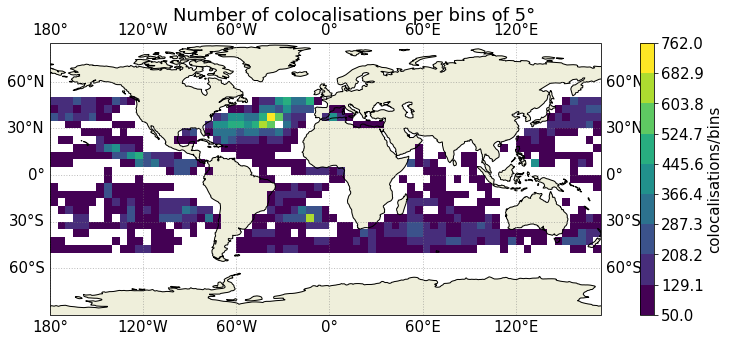

In [5]:
#import matplotlib.ticker as mticker

fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ds.nb_coloc_bins.plot(x='lon_bin', y='lat_bin', cmap='viridis', levels=10, ax=ax, vmin=min_coloc_bin, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')
#gl.xlabels_top = False
#gl.ylabels_left = False
#gl.xlines = False
#gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
#gl.xformatter = LONGITUDE_FORMATTER
#gl.yformatter = LATITUDE_FORMATTER

fig.suptitle(f'Number of colocalisations per bins of {dl}°')

# LON LAT bins

In [6]:
ds.mean_sum_co_adt_oceantide_es_cstrio_z15_alti_x.attrs = {'long_name':r'$\langle S *sin(\phi)\rangle $ with $g\partial_x(adt+oceantide)$' }
ds.mean_sum_aviso_adt_es_cstrio_z15_drifter_x.attrs = {'long_name':r'$\langle S *sin(\phi)\rangle$ with AVISO $g\partial_xadt_{driftermatchup}$' }

## Mean of individual terms

In [14]:
def plot_stat_lonlat(ds, variables, cmap='RdYlBu_r', fig_title=1):
    nrows = ceil(len(variables)/2)
    ncols = 2
    lettres = ['('+l+')' for l in list(string.ascii_lowercase)]
    # Define the figure and each axis for the 3 rows and 3 columns
    fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                            subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(16,nrows*4))

    # axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
    axs=axs.flatten()

    #Loop over all of the variables
    for i in range(len(variables)):

            # Contour plot
            ds[variables[i]].assign_attrs({'long_name':''}).rename('').plot(x='lon_bin', y='lat_bin', cmap=cmap, ax=axs[i], vmin=-2e-5, vmax=2e-5)

            # Title each subplot with the name of the model
            axs[i].set_title(lettres[i]+'\n' +ds[variables[i]].attrs['long_name'])

            # Draw the coastines for each subplot
            axs[i].coastlines()
            axs[i].add_feature(cfeature.LAND)
            gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle=':')
            gl.xlabels_top = False
            gl.ylabels_right = False
            
            #axs[i].colorbar(label='')
            
    if isinstance(fig_title, str):
        fig.suptitle(fig_title)
    fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
    # Delete the unwanted axes
    for i in np.arange(len(variables),nrows*2):
        fig.delaxes(axs[i])

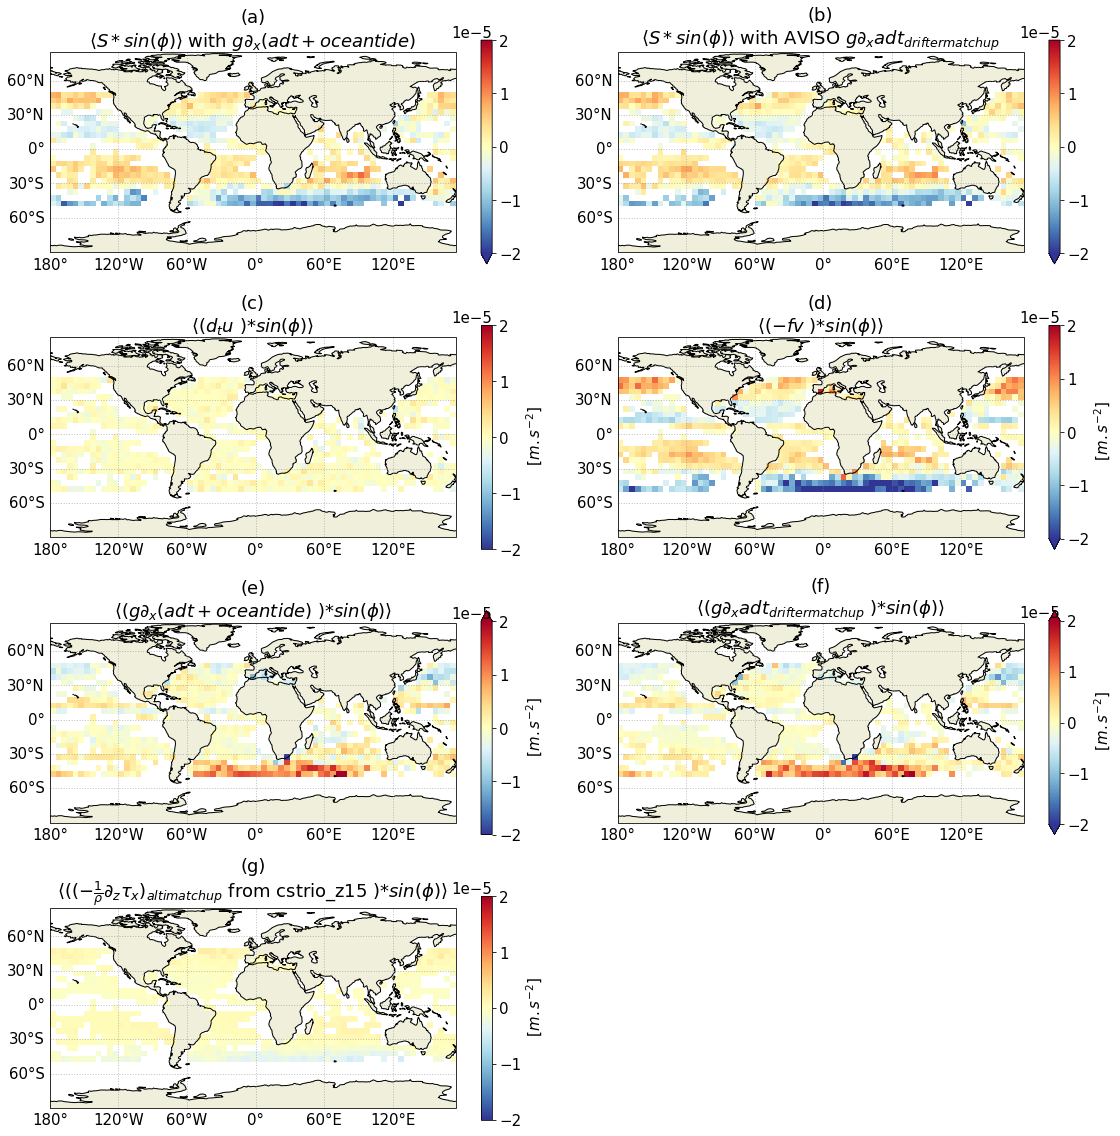

In [15]:
variables=['mean_sum_co_adt_oceantide_es_cstrio_z15_alti_x','mean_sum_aviso_adt_es_cstrio_z15_drifter_x',
           'mean_drifter_acc_x','mean_drifter_coriolis_x',
           'mean_alti_adt_oceantide_g_grad_x','mean_aviso_drifter_adt_g_grad_x',
           'mean_es_cstrio_z15_alti_wd_x',]
plot_stat_lonlat(ds, variables)

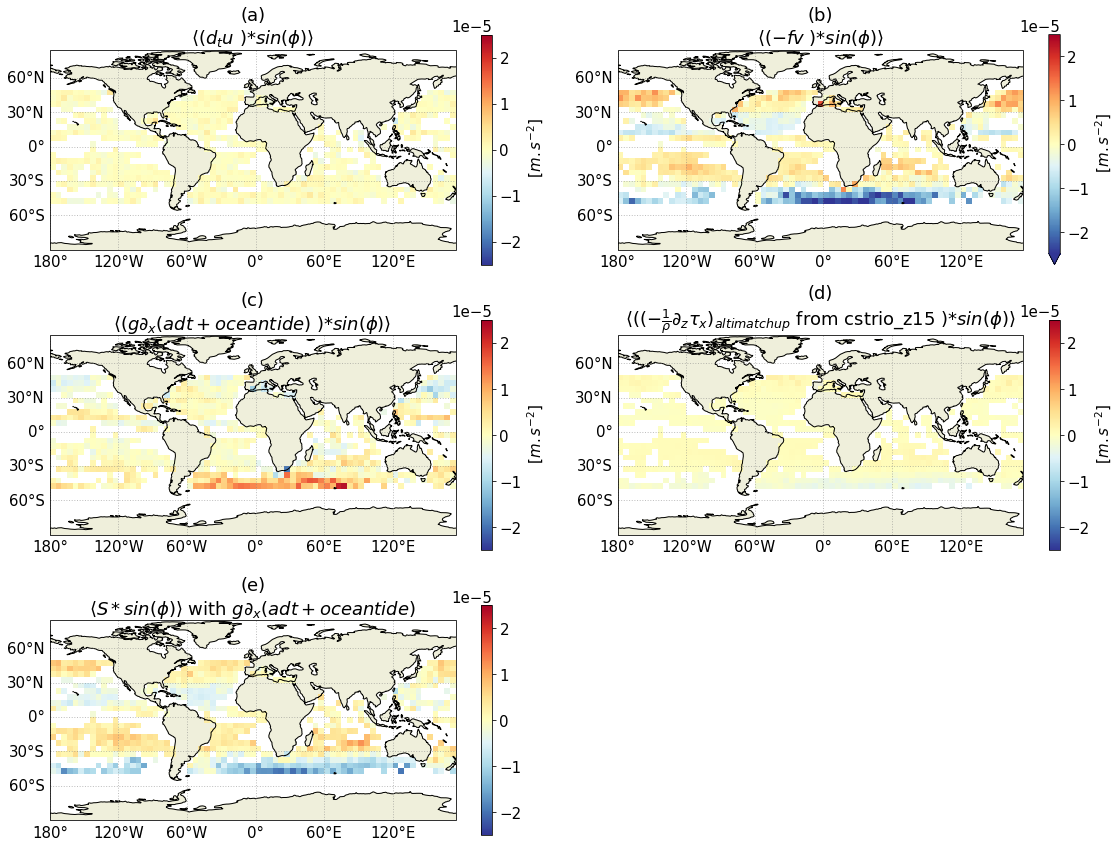

In [11]:
variables=['mean_drifter_acc_x','mean_drifter_coriolis_x',
           'mean_alti_adt_oceantide_g_grad_x','mean_es_cstrio_z15_alti_wd_x',
    'mean_sum_co_adt_oceantide_es_cstrio_z15_alti_x',]
plot_stat_lonlat(ds, variables)

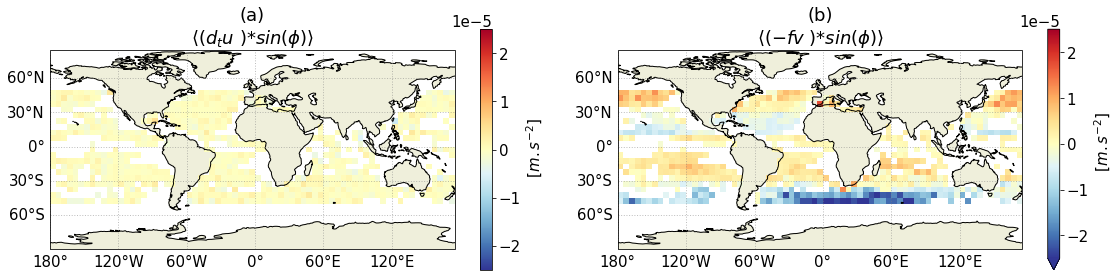

In [12]:
variables=['mean_drifter_acc_x','mean_drifter_coriolis_x',]
plot_stat_lonlat(ds, variables)

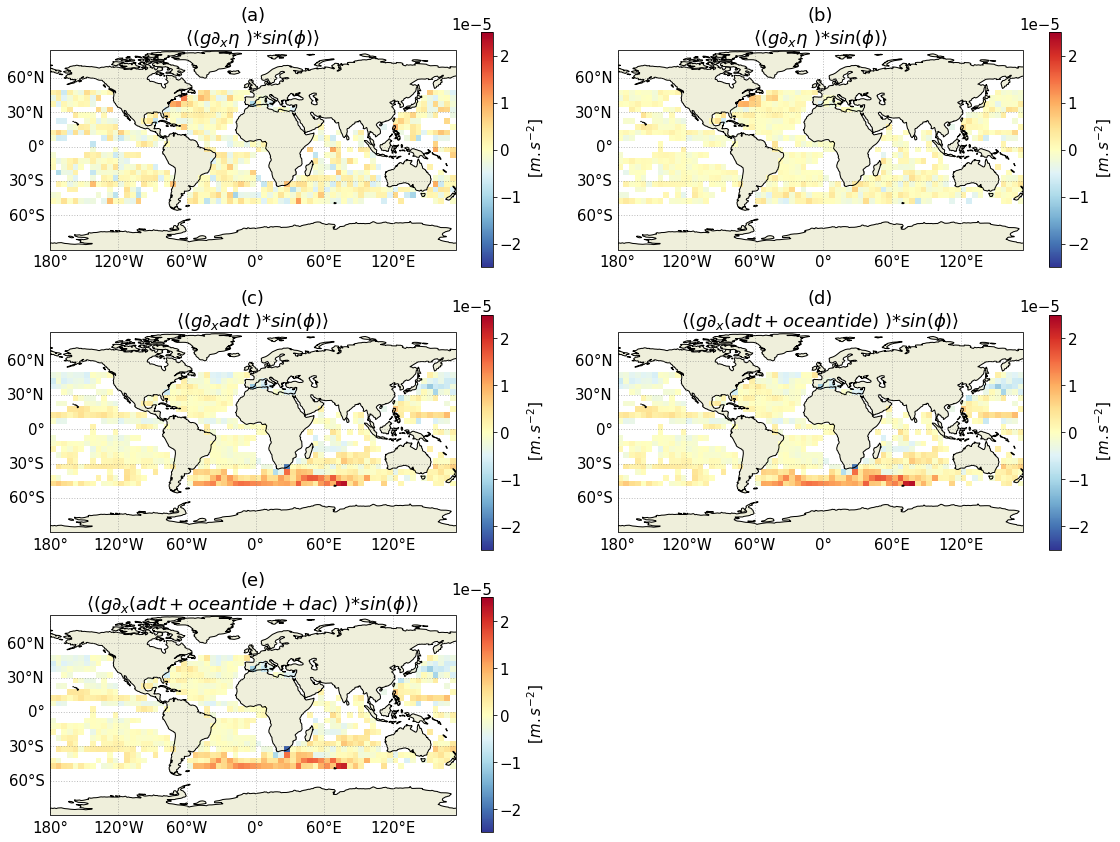

In [13]:
variables=['mean_alti_g_grad_x','mean_alti_denoised_g_grad_x','mean_alti_adt_g_grad_x','mean_alti_adt_oceantide_g_grad_x','mean_alti_adt_oceantide_dac_g_grad_x']
plot_stat_lonlat(ds, variables)

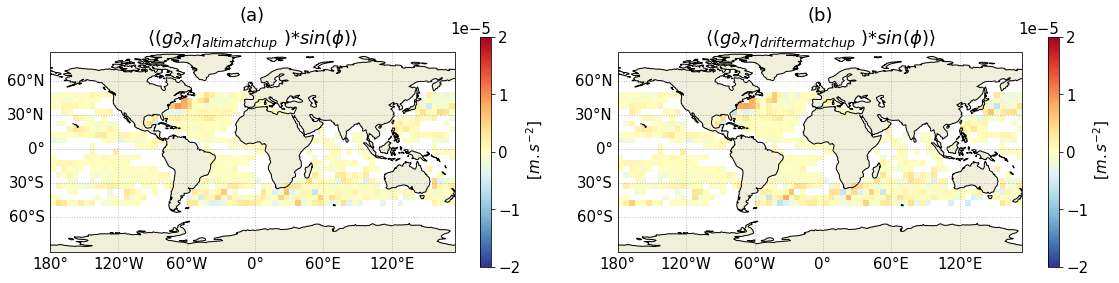

In [17]:
variables=['mean_aviso_alti_g_grad_x','mean_aviso_drifter_g_grad_x']
plot_stat_lonlat(ds, variables)

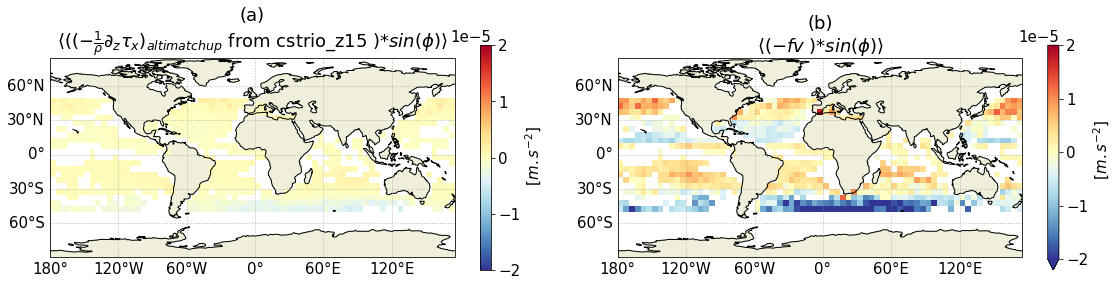

In [18]:
variables=['mean_es_cstrio_z15_alti_wd_x','mean_drifter_coriolis_x',]
plot_stat_lonlat(ds, variables)

In [19]:
cluster.close()